In [1]:
library(tidyverse)
library(igraph)

source('../utils/plottingUtilities.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: scales


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

  

In [2]:
# from this, we really just need late$template
load('../data/lateData.Rdata')

In [49]:
# load irf fits
load('../scripts/irf_fits_2020-04-13/irfSpatialFit_gut_set12pp.Rdata')

In [50]:
ls()

[1] "edges"            "fit"              "gene"             "gene1"           
 [5] "gene2"            "generateImage"    "getNodeImages"    "getNodeLabel"    
 [9] "getNodePosition"  "i"                "img2Color"        "indx"            
[13] "interaction1"     "interaction2"     "interactions"     "iRF.graph"       
[17] "la"               "late"             "mapLate2Early"    "multiplot"       
[21] "network.mat"      "overlayImage"     "overlayImages"    "p"               
[25] "plot_all_PPs"     "plotGroupImg"     "plotImg"          "plotPP"          
[29] "shiftHoriz"       "shiftImg"         "shiftVert"        "sign1"           
[33] "sign2"            "stability.scores" "test.id"          "tf"              
[37] "train.id"         "unique.genes"     "x.late"           "y.late"

# get interactions

In [51]:
interactions <- fit$interaction[, 1]

In [52]:
interactions

[1] "Pdp1+_Ugt36Bc+" "dm+_Pdp1+"      "Klp3A-_Pdp1+"   "CG13900-_Pdp1+"
 [5] "CG10645-_Pdp1+" "Pdp1+_wg-"      "Mes2+_Pdp1+"    "CG3227-_Pdp1+" 
 [9] "Pdp1+_Ptx1+"    "cad+_Pdp1+"     "CG5971-_Pdp1+"  "CG9467+_Pdp1+" 
[13] "Ptx1+_Rapgap1+" "Pdp1+_Ugt36Bc-" "CG9232+_Pdp1+"  "CG9232+_Ptx1+" 
[17] "Pdp1+_Sdc-"     "CG10267-_Pdp1+"

In [53]:
# first gene
interaction1 <- gsub('[+, -]_.*', "", unlist(interactions))
print(interaction1)

sign1 <- substr(interactions,nchar(interaction1)+1,nchar(interaction1)+1)

 [1] "Pdp1"    "dm"      "Klp3A"   "CG13900" "CG10645" "Pdp1"    "Mes2"   
 [8] "CG3227"  "Pdp1"    "cad"     "CG5971"  "CG9467"  "Ptx1"    "Pdp1"   
[15] "CG9232"  "CG9232"  "Pdp1"    "CG10267"


In [54]:
# second_gene
interaction2 <- gsub('.*[+, -]_', "", unlist(interactions))

sign2 <- substr(interaction2,nchar(interaction2),nchar(interaction2)) 

interaction2 <- substr(interaction2,1,nchar(interaction2)-1) 

In [55]:
interaction2

[1] "Ugt36Bc" "Pdp1"    "Pdp1"    "Pdp1"    "Pdp1"    "wg"      "Pdp1"   
 [8] "Pdp1"    "Ptx1"    "Pdp1"    "Pdp1"    "Pdp1"    "Rapgap1" "Ugt36Bc"
[15] "Pdp1"    "Ptx1"    "Sdc"     "Pdp1"

In [56]:
# just check for my sanity regex logic is correct
all(interactions == paste0(interaction1, sign1, '_', interaction2, sign2))

[1] TRUE

# Plot a few interactoins

In [57]:
indx <- seq(1, 8)

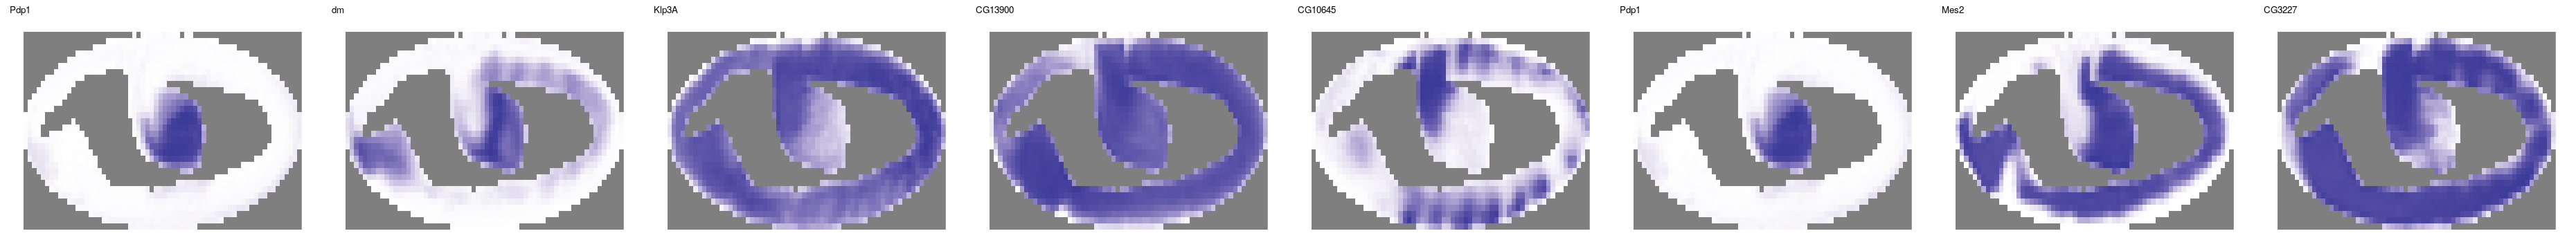

In [58]:
p <- list()

for(i in 1:length(indx)){
    gene <- interaction1[indx[i]]
    p[[i]] <- plotImg(x.late[, gene], late$template, FALSE, gene)       
}

options(repr.plot.width = 31, repr.plot.height = 3)
multiplot(plotlist = p, cols = length(indx))


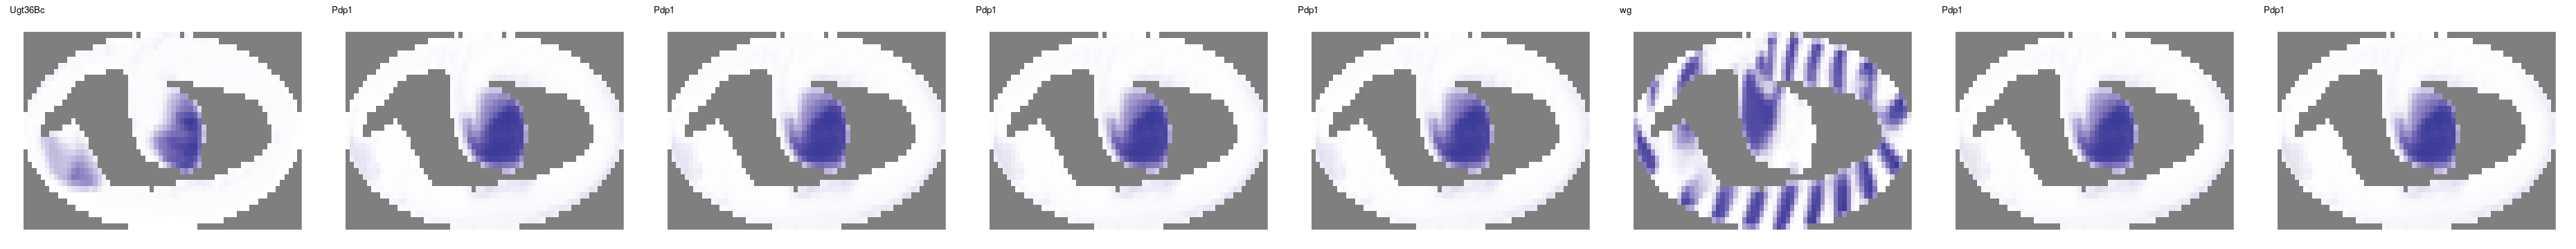

In [59]:
p <- list()

for(i in 1:length(indx)){
    gene <- interaction2[indx[i]]
    p[[i]] <- plotImg(x.late[, gene], late$template, FALSE, gene)       
}

options(repr.plot.width = 31, repr.plot.height = 3)
multiplot(plotlist = p, cols = length(indx))


In [60]:
interactions[indx]

[1] "Pdp1+_Ugt36Bc+" "dm+_Pdp1+"      "Klp3A-_Pdp1+"   "CG13900-_Pdp1+"
[5] "CG10645-_Pdp1+" "Pdp1+_wg-"      "Mes2+_Pdp1+"    "CG3227-_Pdp1+"

# Construct graph

In [61]:
unique.genes <- unique(c(interaction1, interaction2))

In [62]:
network.mat <- matrix(rep(0, length(unique.genes)**2), ncol = length(unique.genes))
colnames(network.mat) <- unique.genes
rownames(network.mat) <- unique.genes

In [63]:
stability.scores <- fit$interaction[, 'stability'] + 1e-6

In [64]:
edges <- rep(0, length(interaction1))
for(i in 1:length(interaction1)){
    gene1 <- interaction1[i]
    gene2 <- interaction2[i]
    
    if(sign1[i] == sign2[i]){
        network.mat[gene1, gene2] <- 1 * stability.scores[i]
        network.mat[gene2, gene1] <- 1 * stability.scores[i]
    }
    if(sign1[i] != sign2[i]){
        network.mat[gene1, gene2] <- -1 * stability.scores[i]
        network.mat[gene2, gene1] <- -1 * stability.scores[i]
    }
        
}

In [65]:
iRF.graph <- graph_from_adjacency_matrix(network.mat, weighted = TRUE,
                                   diag = FALSE, 
                                    mode = 'upper')


In [66]:
la <- layout_with_dh(iRF.graph)

In [67]:
E(iRF.graph)$color[E(iRF.graph)$weight > 0] <- 'red'
E(iRF.graph)$color[E(iRF.graph)$weight < 0] <- 'blue'

In [68]:
E(iRF.graph)$width <- abs(E(iRF.graph)$weight) * 10

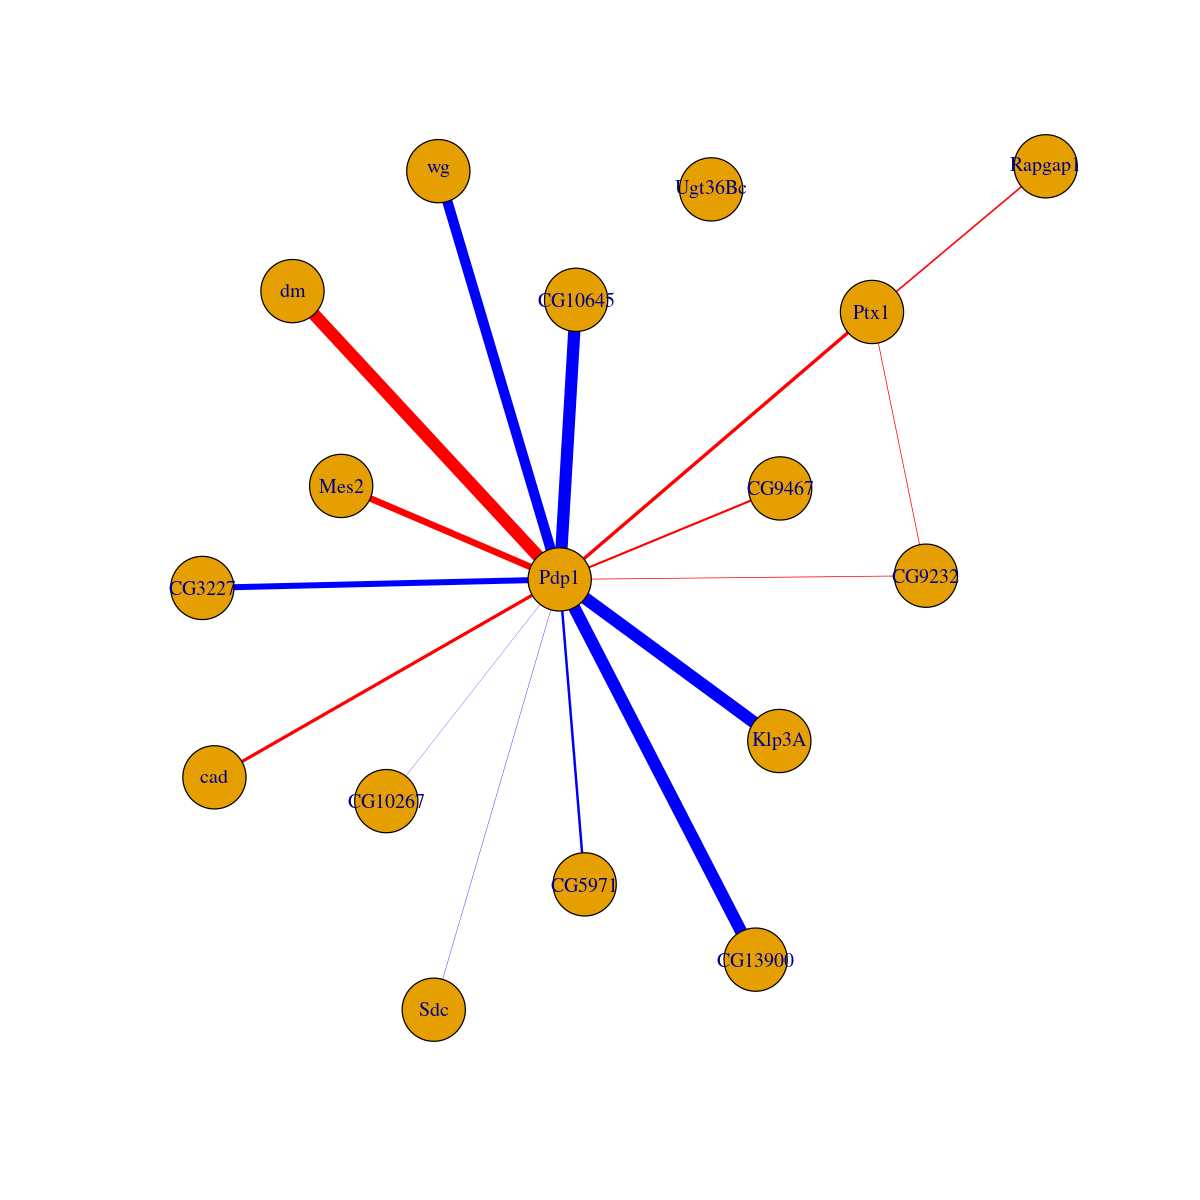

In [69]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot(iRF.graph, layout = la, edge.width=E(iRF.graph)$width)

In [70]:
interactions

[1] "Pdp1+_Ugt36Bc+" "dm+_Pdp1+"      "Klp3A-_Pdp1+"   "CG13900-_Pdp1+"
 [5] "CG10645-_Pdp1+" "Pdp1+_wg-"      "Mes2+_Pdp1+"    "CG3227-_Pdp1+" 
 [9] "Pdp1+_Ptx1+"    "cad+_Pdp1+"     "CG5971-_Pdp1+"  "CG9467+_Pdp1+" 
[13] "Ptx1+_Rapgap1+" "Pdp1+_Ugt36Bc-" "CG9232+_Pdp1+"  "CG9232+_Ptx1+" 
[17] "Pdp1+_Sdc-"     "CG10267-_Pdp1+"